In [26]:
%matplotlib inline

import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import geopandas as gpd
plt.rcParams['figure.figsize'] = (15,9)
from rasterstats import zonal_stats
from rasterio.transform import Affine
from scipy.interpolate import griddata
import rasterio
from matplotlib.patches import Rectangle

In [95]:
import scipy.stats

In [27]:
import cartopy.crs as ccrs

In [28]:
shapefile= gpd.read_file('greatlakes_subbasins.shp')

In [29]:
ds1 = xr.open_dataset('zg_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_195001-201412.nc')
hgt = ds1.zg.sel(lat=slice(-10,90), lon=slice(180, 360),plev=slice(6) ,time=slice('1979-01-01','2014-12-31'))
lat_zg = ds1.lat.sel(lat=slice(-10,90))
lon_zg = ds1.lon.sel(lon=slice(180, 360))

In [30]:
ds1.plev

<xarray.DataArray 'plev' (plev: 19)>
array([100000.,  92500.,  85000.,  70000.,  60000.,  50000.,  40000.,  30000.,
        25000.,  20000.,  15000.,  10000.,   7000.,   5000.,   3000.,   2000.,
         1000.,    500.,    100.])
Coordinates:
  * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
Attributes:
    bounds:         plev_bnds
    units:          Pa
    axis:           Z
    positive:       down
    long_name:      pressure
    standard_name:  air_pressure

In [31]:
hgt2d = hgt.values
ntime,nlevel, nrow_zg, ncol_zg = hgt2d.shape
print(nrow_zg,ncol_zg)

80 96


In [62]:
a= pd.read_csv("z_anom_ac.csv")
b=pd.read_csv("ac_anom_mean.csv")
b

Unnamed: 0      Erie     Huron  Michigan   Ontario  superior
0            1  3.650070  1.747130  1.861775  4.079298  1.619462
1            2  3.673251  2.575333  2.628926  3.203232  2.376594
2            3  3.408620  3.583147  3.545513  3.558824  2.733960
3            4  3.273712  3.396055  2.684456  4.089131  3.775085
4            5  2.746200  3.043186  2.205097  3.550927  3.721362
5            6  2.279202  1.966000  1.952860  2.825510  1.862733
6            7  2.868202  1.851212  2.141558  3.880522  2.565689
7            8  3.766877  2.551349  3.570337  3.590837  1.902759
8            9  3.176086  2.720003  2.675683  3.343673  2.062787
9           10  2.637855  3.045374  2.692925  4.638724  2.339509
10          11  2.834581  2.594985  1.941018  3.186379  2.951957
11          12  2.779993  2.266277  1.984048  3.331678  2.101914
12          13  3.415310  2.371983  1.527574  4.050581  1.635000
13          14  2.663560  2.472987  2.931111  2.745218  2.588758
14          15  2.836329  2.951771  1.938510  4.143623  3.270991
15          16  1.958666  2.739300  2.168550  4.105017  3.527567
16          17  2.601698  2.535168  2.237177  4.046802  2.288595
17          18  4.497264  2.200013  2.866583  4.015899  1.897163
18          19  3.207288  2.723858  2.668819  3.609688  2.900920
19          20  1.911274  2.556737  2.341752  3.119531  2.073109
20          21  3.725120  3.363364  3.182356  4.169171  3.343622
21          22  2.985130  3.483758  3.340975  4.120837  4.047617
22          23  3.345376  2.657048  2.612398  3.926241  2.071365
23          24  2.877607  3.241956  3.216598  4.335518  2.711095
24          25  2.062504  2.294740  1.948093  2.431821  3.836992
25          26  3.084440  1.769993  1.960068  3.931310  1.645523
26          27  1.930582  1.288469  1.303327  2.244535  1.071750
27          28  2.991904  2.586114  2.358799  4.117592  2.442759
28          29  3.352847  2.525297  2.438270  3.800104  2.548385
29          30  2.158673  2.440270  2.374870  2.203958  2.277385
30          31  2.455278  2.549474  2.352048  3.574134  2.471332
31          32  2.587449  2.290270  2.481335  2.962500  1.926905
32          33  3.923289  4.191173  4.229396  4.797965  3.616586
33          34  2.592400  3.261887  2.100626  4.047220  3.001088
34          35  3.978923  2.400186  2.600484  3.983715  2.370236
35          36  3.014465  2.835142  2.495517  3.443631  3.095544

In [63]:
a= a.drop(['Unnamed: 0'],axis=1)
b= b.drop(['Unnamed: 0'],axis=1)
b['mean']= b.mean(axis=1)
a_t= a.T

In [51]:
a_zg = PCA(n_components=3)
a_zg.fit(a_t)
a_reduced= a_zg.transform(a_t)
zg_f=a_zg.inverse_transform(a_reduced)


In [54]:
rp= np.reshape(zg_f,(nrow_zg,ncol_zg,36),order='F')
range(rp.shape[0])

(80, 96, 36)

In [103]:
cor_ac= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_ac[:] = np.nan
cor_ac_p= np.empty((nrow_zg,ncol_zg),dtype=object)
cor_ac_p[:] = np.nan

In [108]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_ac[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[0]
        
        
        

In [111]:
for i in range((rp.shape[0])):
    for j in range((rp.shape[1])):
        cor_ac_p[i,j] = scipy.stats.spearmanr(rp[i,j,],b['mean'])[1]
        

In [114]:
ac_sign= np.zeros([80,96])

In [115]:
for i in range(ac_sign.shape[0]):
    for j in range(ac_sign.shape[1]):
        if cor_ac_p[i,j]<0.1:
            ac_sign[i,j]= ac_sign[i,j]+1
        else:
            ac_sign[i,j]= ac_sign[i,j]+0

In [118]:
y,x=np.where(ac_sign>0)


In [125]:
y

array([54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56,
       56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58,
       58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
       61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63,
       63, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65,
       65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 68],
      dtype=int64)

In [119]:
x_list1= x.tolist()
y_list1=y.tolist()
lat_np= lat_zg.to_numpy()
lat_ls= lat_np.tolist()
lon_np=lon_zg.to_numpy()
lon_ls= lon_np.tolist()

In [127]:
lat_list1= []
for values in list(range(len(x_list1))):
    lat_list1.append(lat_ls[x_list1[values]])
    

In [128]:
lon_list1= []
for values in list(range(len(y_list1))):
    lon_list1.append(lon_ls[y_list1[values]])

In [129]:
lat_list1

[63.125,
 64.375,
 66.875,
 68.125,
 49.375,
 50.625,
 51.875,
 53.125,
 54.375,
 55.625,
 56.875,
 58.125,
 59.375,
 60.625,
 61.875,
 48.125,
 49.375,
 50.625,
 55.625,
 74.375,
 75.625,
 76.875,
 66.875,
 68.125,
 69.375,
 70.625,
 71.875,
 73.125,
 74.375,
 75.625,
 76.875,
 63.125,
 64.375,
 65.625,
 66.875,
 68.125,
 69.375,
 70.625,
 71.875,
 73.125,
 60.625,
 61.875,
 63.125,
 64.375,
 65.625,
 66.875,
 68.125,
 69.375,
 56.875,
 58.125,
 59.375,
 60.625,
 61.875,
 63.125,
 64.375,
 65.625,
 66.875,
 68.125,
 54.375,
 55.625,
 56.875,
 58.125,
 59.375,
 60.625,
 61.875,
 63.125,
 64.375,
 65.625,
 66.875,
 54.375,
 55.625,
 56.875,
 58.125,
 59.375,
 60.625,
 61.875,
 63.125,
 64.375,
 54.375,
 55.625,
 56.875,
 58.125,
 59.375,
 60.625,
 61.875,
 63.125,
 53.125,
 54.375,
 55.625,
 56.875,
 58.125,
 59.375,
 60.625,
 61.875,
 -8.125,
 -6.875,
 51.875,
 53.125,
 54.375,
 55.625,
 56.875,
 58.125,
 59.375,
 60.625,
 50.625,
 51.875,
 53.125,
 54.375,
 55.625,
 56.875,
 58.125,
 

In [79]:
len(rp[1,1,])

36

In [17]:
a2d_pcs =  a_zg.inverse_transform(a_zg.transform(a))

In [22]:
a_zg

PCA(n_components=3)

In [31]:
b2d_pcs =  b

In [32]:
b

Erie     Huron  Michigan   Ontario  superior
0   3.650070  1.747130  1.861775  4.079298  1.619462
1   3.673251  2.575333  2.628926  3.203232  2.376594
2   3.408620  3.583147  3.545513  3.558824  2.733960
3   3.273712  3.396055  2.684456  4.089131  3.775085
4   2.746200  3.043186  2.205097  3.550927  3.721362
5   2.279202  1.966000  1.952860  2.825510  1.862733
6   2.868202  1.851212  2.141558  3.880522  2.565689
7   3.766877  2.551349  3.570337  3.590837  1.902759
8   3.176086  2.720003  2.675683  3.343673  2.062787
9   2.637855  3.045374  2.692925  4.638724  2.339509
10  2.834581  2.594985  1.941018  3.186379  2.951957
11  2.779993  2.266277  1.984048  3.331678  2.101914
12  3.415310  2.371983  1.527574  4.050581  1.635000
13  2.663560  2.472987  2.931111  2.745218  2.588758
14  2.836329  2.951771  1.938510  4.143623  3.270991
15  1.958666  2.739300  2.168550  4.105017  3.527567
16  2.601698  2.535168  2.237177  4.046802  2.288595
17  4.497264  2.200013  2.866583  4.015899  1.897163
18  3.207288  2.723858  2.668819  3.609688  2.900920
19  1.911274  2.556737  2.341752  3.119531  2.073109
20  3.725120  3.363364  3.182356  4.169171  3.343622
21  2.985130  3.483758  3.340975  4.120837  4.047617
22  3.345376  2.657048  2.612398  3.926241  2.071365
23  2.877607  3.241956  3.216598  4.335518  2.711095
24  2.062504  2.294740  1.948093  2.431821  3.836992
25  3.084440  1.769993  1.960068  3.931310  1.645523
26  1.930582  1.288469  1.303327  2.244535  1.071750
27  2.991904  2.586114  2.358799  4.117592  2.442759
28  3.352847  2.525297  2.438270  3.800104  2.548385
29  2.158673  2.440270  2.374870  2.203958  2.277385
30  2.455278  2.549474  2.352048  3.574134  2.471332
31  2.587449  2.290270  2.481335  2.962500  1.926905
32  3.923289  4.191173  4.229396  4.797965  3.616586
33  2.592400  3.261887  2.100626  4.047220  3.001088
34  3.978923  2.400186  2.600484  3.983715  2.370236
35  3.014465  2.835142  2.495517  3.443631  3.095544

In [33]:
cca = CCA(n_components=4)
a_c, b_c = cca.fit_transform(b2d_pcs, a2d_pcs)

In [34]:
r1=np.corrcoef(a_c[:, 0], b_c[:, 0])
r1

array([[1.        , 0.61825013],
       [0.61825013, 1.        ]])

In [35]:
A = cca.x_weights_ 
B = cca.y_weights_
BB = np.reshape(B,(nrow_zg,ncol_zg,4),order='F')
BB_1= BB[:,:,0]


In [36]:
shapefile['cca1']= A[:,0]
shapefile.head()

merge                                           geometry      cca1
0   lk_erie  POLYGON ((-80.27591 44.09303, -80.26687 44.085...  0.206002
1  lk_huron  POLYGON ((-79.85601 47.28073, -79.85985 47.239...  0.649485
2   lk_mich  POLYGON ((-86.11485 46.54744, -86.11092 46.546...  0.062158
3    lk_ont  POLYGON ((-78.40375 45.35472, -78.40661 45.341... -0.554781
4    lk_sup  POLYGON ((-88.52978 50.74652, -88.50701 50.692... -0.473378

In [37]:
xmax,ymin,xmin,ymax= shapefile.total_bounds
d1=xmax-xmin
d2=ymax-ymin
rect =Rectangle((xmin, ymin), d1, d2, facecolor="none", ec='k', lw=2)

In [102]:
cor_ac.min()

-0.24177733506247132

Text(0.5, 1.0, 'ACCESS')

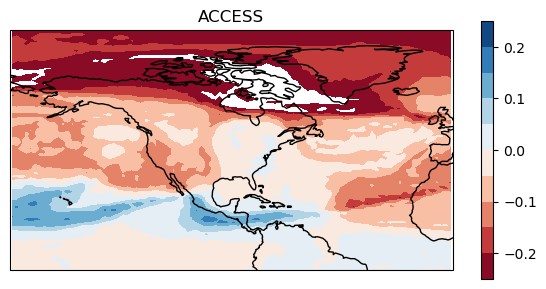

In [143]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax2 = fig.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
x1, y1 = np.meshgrid(lon_zg, lat_zg)
level= np.arange(-0.25,0.30,0.05)
cs = ax2.contourf(x1, y1, cor_ac,level,
                        
                        transform=ccrs.PlateCarree(),
                        cmap='RdBu')
    
cb=fig.colorbar(cs, ax=ax2, shrink=0.8, aspect=20)  
ax2.plot(lon_list1,lat_list1,marker='o', color='tab:red')
ax2.coastlines()
ax2.set_global()
ax2.set_extent([-180,0,-7.5,90],crs=ccrs.PlateCarree())
ax2.set_title('ACCESS')
#ax2.add_patch(rect)
#fig.savefig('CCA1_basin_ac')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


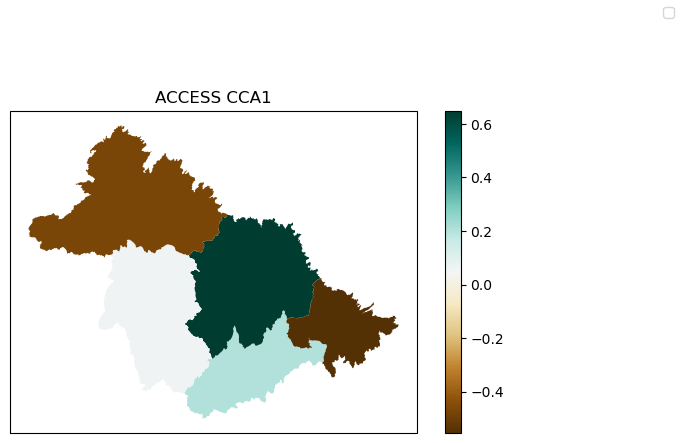

In [47]:
fig2 = plt.figure()
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.1, hspace=0.15)

ax1 = fig2.add_subplot(gs[0,1],  projection=ccrs.PlateCarree())
shapefile.plot(ax=ax1,column ="cca1", cmap = reversed_map,legend= True)
ax1.set_title('ACCESS CCA1')
fig2.legend()
fig2.savefig('ac_pr')

In [57]:
a_c /= a_c.std(axis=0)
b_c /= b_c.std(axis=0)


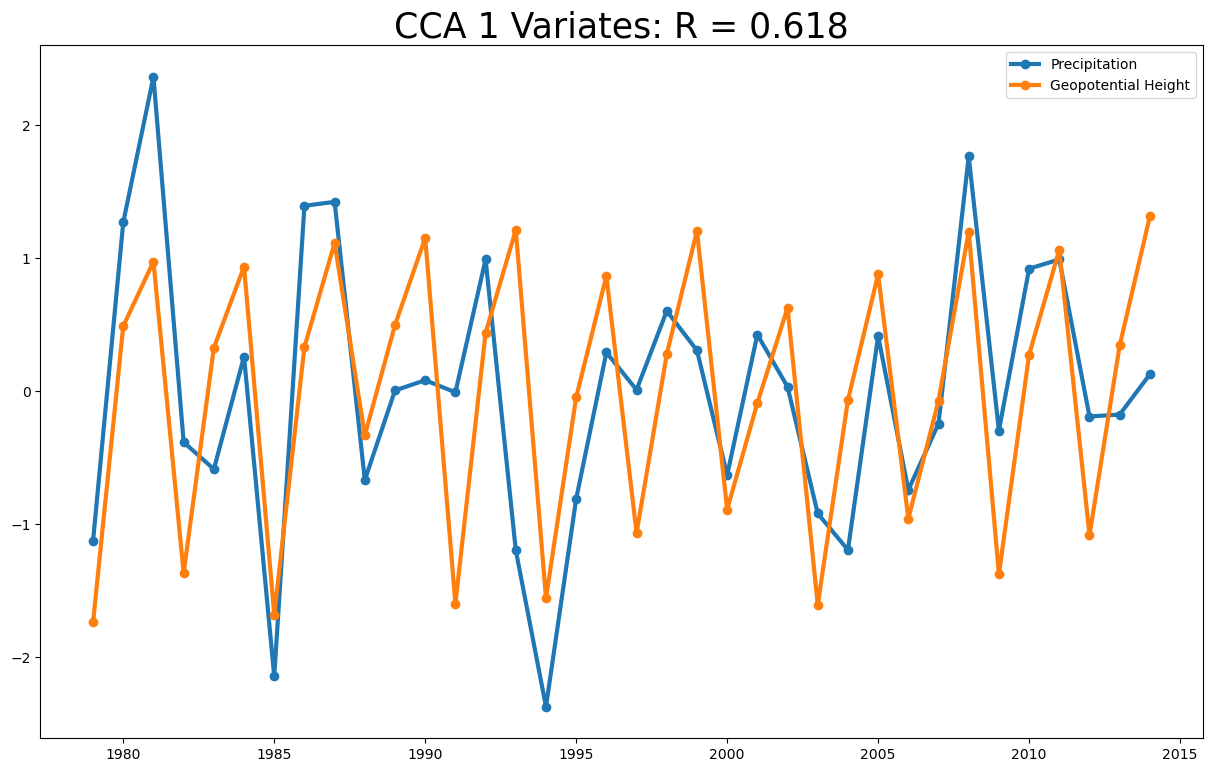

In [58]:
year = list(range(1979,2015))
fontsize = 25
plt.plot(year, a_c[:,0],"-o", label='Precipitation',linewidth=3)
plt.plot(year, b_c[:,0],"-o", label='Geopotential Height',linewidth=3)
plt.title('CCA 1 Variates: R = ' + str(round(r1[0,1],3)),fontdict={'fontsize': fontsize})
plt.legend()
plt.savefig('basin_ac')

In [61]:
cca_corr= cca.coef_
cca_eigenvalues = np.diag(cca_corr @ cca_corr.T)
cca_variance_ratio = cca_eigenvalues / np.sum(cca_eigenvalues)

C:\Users\tameem\AppData\Roaming\Python\Python38\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


In [62]:
cca_variance_ratio


array([0.20397999, 0.19177996, 0.23253093, 0.12058151, 0.25112761])